In [262]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

C:\Users\karna\AppData\Local\Temp\ipykernel_8964\3777615979.py:1: DeprecationWarning:

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display



In [263]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [264]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

pd.set_option('display.max_columns', None)

In [265]:
data = pd.read_csv('data/cleaned_5272.csv')

In [266]:
data.head()

,pl_name,hostname,sy_snum,sy_pnum,discoverymethod,disc_year,pl_orbper,pl_orbeccen,pl_orbsmax,pl_rade,pl_radj,pl_bmasse,pl_bmassj,pl_insol,pl_eqt,st_spectype,st_teff,st_rad,st_mass,st_met,st_metratio,st_logg,sy_dist,planet_type
0,11 Com b,11 Com,2,1,Radial Velocity,2007,326.030000,0.231000,1.290000,NaN,NaN,6165.60000,19.40000,NaN,NaN,G8 III,4742.0,19.00,2.70,-0.35,[Fe/H],2.31,93.1846,Gas Giant
1,11 UMi b,11 UMi,1,1,Radial Velocity,2009,516.219970,0.080000,1.530000,NaN,NaN,4684.81420,14.74000,NaN,NaN,NaN,4213.0,29.79,2.78,-0.02,[Fe/H],1.93,125.3210,Gas Giant
2,14 And b,14 And,1,1,Radial Velocity,2008,185.840000,0.000000,0.830000,NaN,NaN,1525.50000,4.80000,NaN,NaN,K0 III,4813.0,11.00,2.20,-0.24,[Fe/H],2.63,75.4392,Gas Giant
3,14 Her b,14 Her,1,2,Radial Velocity,2002,1765.038901,0.372689,2.773069,NaN,NaN,2586.74645,8.13881,NaN,NaN,NaN,NaN,NaN,0.91,NaN,NaN,NaN,17.9323,Gas Giant
4,16 Cyg B b,16 Cyg B,3,1,Radial Velocity,1996,798.500000,0.680000,1.660000,NaN,NaN,565.73740,1.78000,NaN,NaN,NaN,5750.0,1.13,1.08,0.06,[Fe/H],4.36,21.1397,Gas Giant


# Pre-Processing

### Choose features

* Categorical Variables are ignored as they aren't suitable for k-means.
* Some continuous variables like pl_insol, pl_eqt, p_orbeccen are removed as they have more than 60% data as NA. Can impute, but the values will be inflated.

In [267]:
features = ['pl_orbper','pl_orbsmax','pl_rade','pl_bmasse','st_teff','st_rad','st_mass','st_met','st_logg','sy_dist','planet_type'] 

In [268]:
cluster_data = data.loc[:,features].dropna()
cluster_data.shape

(648, 11)

In [269]:
cluster_data.head()

,pl_orbper,pl_orbsmax,pl_rade,pl_bmasse,st_teff,st_rad,st_mass,st_met,st_logg,sy_dist,planet_type
30,7.365474e-01,0.01544,1.875,7.99000,5172.0,0.94,0.91,0.35,4.43,12.5855,Super Earth
77,4.020000e+08,7506.00000,12.442,2002.31896,3406.0,0.39,0.37,0.00,4.83,10.8864,Gas Giant
80,1.324060e+01,0.10550,10.870,874.00000,5075.0,0.79,0.89,0.26,4.65,338.3860,Gas Giant
81,2.994330e+00,0.04360,16.030,740.51000,6440.0,1.37,1.27,-0.03,4.22,655.0370,Gas Giant
82,2.828042e+00,0.04016,16.140,291.43800,5675.0,1.12,1.08,0.16,4.38,1126.3700,Gas Giant


### Remove Outliers

In [270]:
z = np.abs(stats.zscore(cluster_data.loc[:,cluster_data.columns!='planet_type']))

cluster_data = cluster_data[(z<3).all(axis=1)]
cluster_data.shape

(605, 11)

In [271]:
cluster_data_X = cluster_data.drop('planet_type',axis=1)
cluster_data_Y = cluster_data['planet_type']

In [272]:
cluster_data_X.describe()

,pl_orbper,pl_orbsmax,pl_rade,pl_bmasse,st_teff,st_rad,st_mass,st_met,st_logg,sy_dist
count,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000
mean,22.468717,0.106439,9.131147,273.884891,5397.447934,1.088744,0.977306,0.058170,4.395140,350.196239
std,95.795784,0.215458,5.778027,380.724036,843.068994,0.434068,0.283438,0.195149,0.236841,304.383593
min,0.321962,0.007100,0.510000,0.070000,2850.000000,0.160000,0.120000,-0.500000,3.600000,6.531270
25%,2.879232,0.038150,2.870000,12.970000,4985.000000,0.790000,0.810000,-0.060000,4.220000,114.173000
50%,4.231306,0.052080,10.760000,139.845200,5570.000000,0.990000,0.970000,0.070000,4.410000,275.587000
75%,10.288910,0.090300,13.585000,349.611250,5978.000000,1.390000,1.170000,0.200000,4.550000,486.474000
max,1107.592300,2.720500,23.371000,2302.899000,7800.000000,2.590000,1.900000,0.522000,5.130000,1477.980000


### Histograms of chosen data

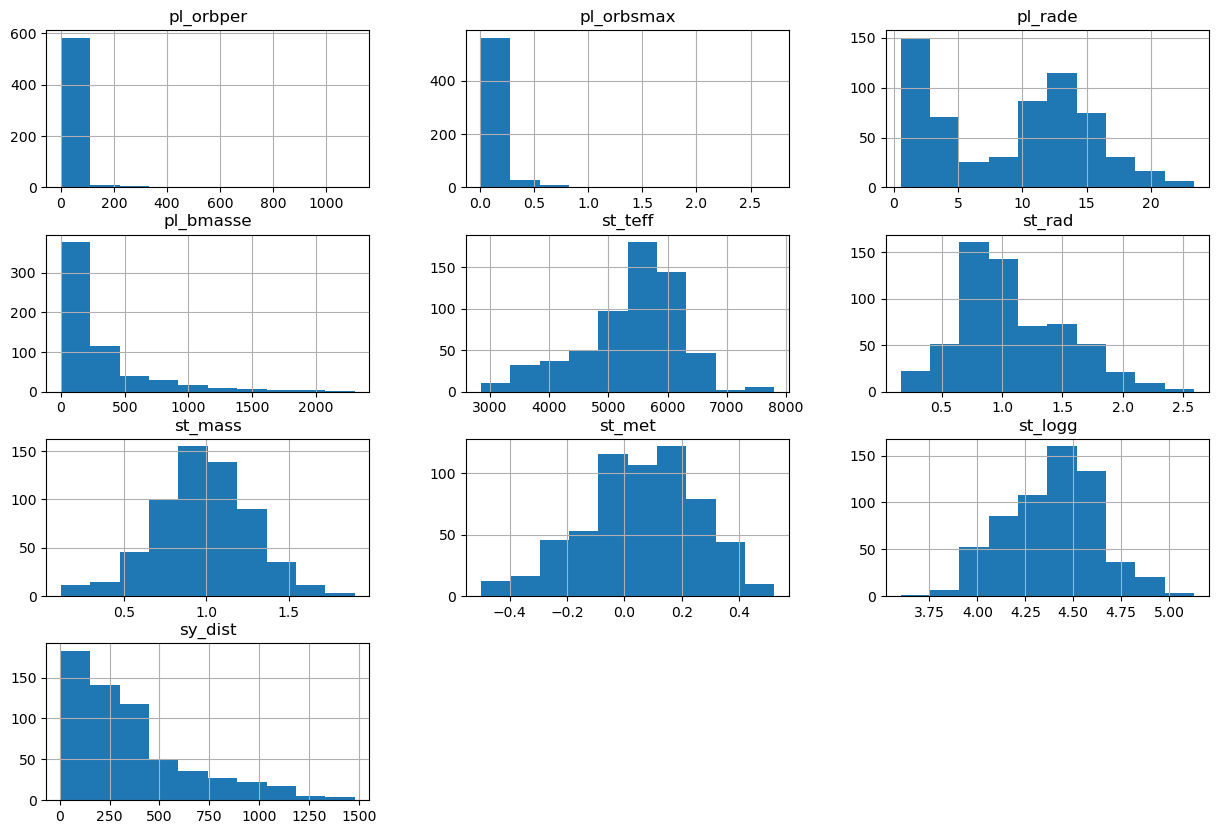

In [273]:
cluster_data_X.hist(bins=10, figsize=(15, 10));

### Histograms after standardizing

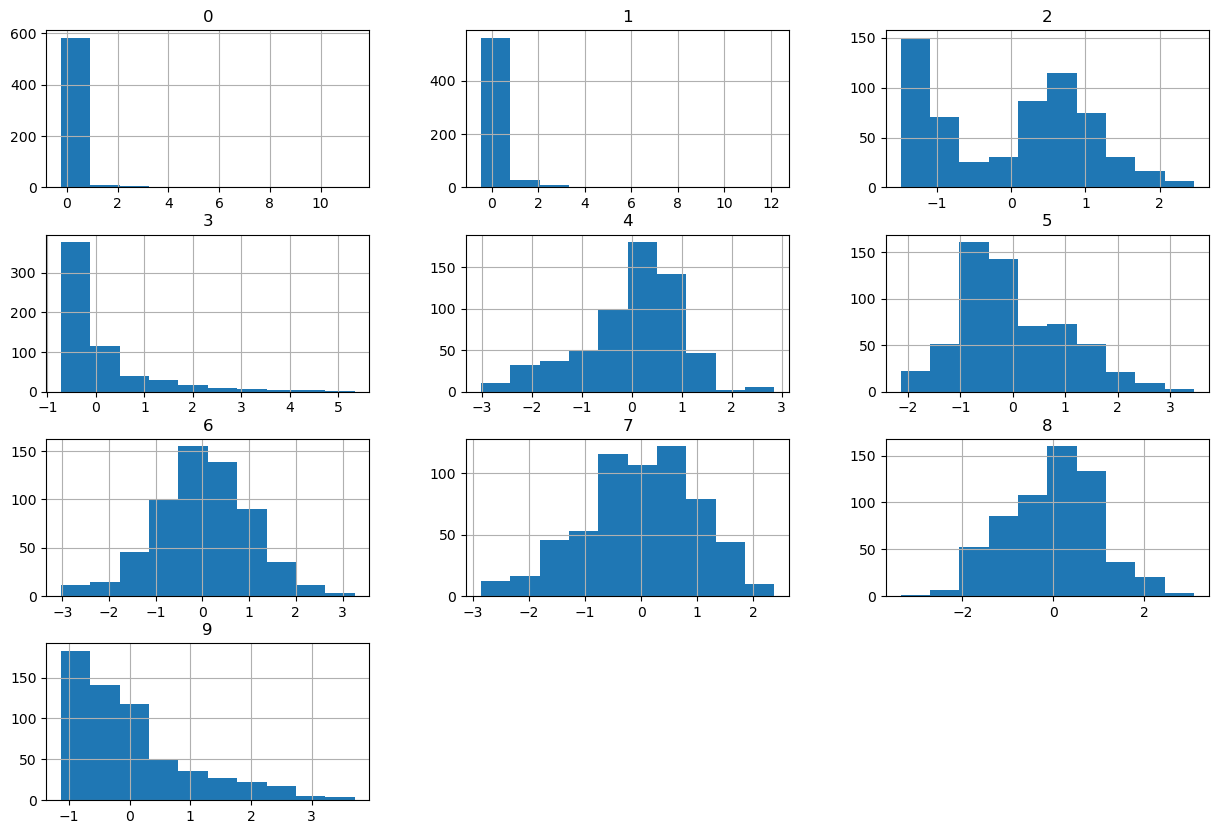

In [274]:
scaler = StandardScaler()
scaled_data_X = pd.DataFrame(scaler.fit_transform(cluster_data_X))
scaled_data_X.hist(bins=10, figsize=(15, 10));

In [275]:
scaled_data_X.describe()

,0,1,2,3,4,5,6,7,8,9
count,6.050000e+02,6.050000e+02,6.050000e+02,6.050000e+02,6.050000e+02,6.050000e+02,6.050000e+02,6.050000e+02,6.050000e+02,6.050000e+02
mean,5.156573e-17,-1.005623e-16,4.760196e-16,1.108388e-16,2.385603e-17,-4.150950e-16,1.108388e-16,4.991416e-17,-3.994234e-15,-4.128929e-18
std,1.000827e+00,1.000827e+00,1.000827e+00,1.000827e+00,1.000827e+00,1.000827e+00,1.000827e+00,1.000827e+00,1.000827e+00,1.000827e+00
min,-2.313785e-01,-4.614421e-01,-1.493292e+00,-7.197903e-01,-3.024137e+00,-2.141398e+00,-3.027167e+00,-2.862592e+00,-3.360047e+00,-1.129986e+00
25%,-2.046614e-01,-3.172110e-01,-1.084510e+00,-6.858794e-01,-4.896269e-01,-6.888115e-01,-5.907608e-01,-6.060395e-01,-7.400959e-01,-7.760554e-01
50%,-1.905355e-01,-2.525044e-01,2.821379e-01,-3.523565e-01,2.048407e-01,-2.276729e-01,-2.579690e-02,6.066922e-02,6.279220e-02,-2.453187e-01
75%,-1.272487e-01,-7.496775e-02,7.714637e-01,1.990655e-01,6.891873e-01,6.946044e-01,6.804079e-01,7.273779e-01,6.543940e-01,4.480876e-01
max,1.133684e+01,1.214264e+01,2.466523e+00,5.333766e+00,2.852127e+00,3.461436e+00,3.258056e+00,2.378764e+00,3.105316e+00,3.708206e+00


## Log Transformation of some columns

In [276]:
log_cluster_data_X = cluster_data_X.copy()
log_cluster_data_X['pl_orbper'] = np.log(log_cluster_data_X['pl_orbper'])
log_cluster_data_X['pl_orbsmax'] = np.log(log_cluster_data_X['pl_orbsmax'])
log_cluster_data_X['pl_bmasse'] = np.log(log_cluster_data_X['pl_bmasse'])
log_cluster_data_X['sy_dist'] = np.log(log_cluster_data_X['sy_dist'])

In [277]:
log_cluster_data_X.head()

,pl_orbper,pl_orbsmax,pl_rade,pl_bmasse,st_teff,st_rad,st_mass,st_met,st_logg,sy_dist
30,-0.305782,-4.170794,1.875,2.078191,5172.0,0.94,0.91,0.35,4.43,2.532545
80,2.583288,-2.249044,10.870,6.773080,5075.0,0.79,0.89,0.26,4.65,5.824187
81,1.096721,-3.132698,16.030,6.607339,6440.0,1.37,1.27,-0.03,4.22,6.484692
82,1.039585,-3.214884,16.140,5.674827,5675.0,1.12,1.08,0.16,4.38,7.026755
83,1.395053,-2.975930,9.920,6.029973,5945.0,1.01,1.09,0.01,4.46,7.046586


In [278]:
log_cluster_data_X.describe()

,pl_orbper,pl_orbsmax,pl_rade,pl_bmasse,st_teff,st_rad,st_mass,st_met,st_logg,sy_dist
count,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000
mean,1.772000,-2.773191,9.131147,4.345338,5397.447934,1.088744,0.977306,0.058170,4.395140,5.391785
std,1.232912,0.842846,5.778027,1.961491,843.068994,0.434068,0.283438,0.195149,0.236841,1.107177
min,-1.133322,-4.947660,0.510000,-2.659260,2850.000000,0.160000,0.120000,-0.500000,3.600000,1.876601
25%,1.057524,-3.266230,2.870000,2.562639,4985.000000,0.790000,0.810000,-0.060000,4.220000,4.737715
50%,1.442511,-2.954974,10.760000,4.940536,5570.000000,0.990000,0.970000,0.070000,4.410000,5.618903
75%,2.331067,-2.404618,13.585000,5.856822,5978.000000,1.390000,1.170000,0.200000,4.550000,6.187183
max,7.009944,1.000816,23.371000,7.741924,7800.000000,2.590000,1.900000,0.522000,5.130000,7.298432


### Histograms after log transformation

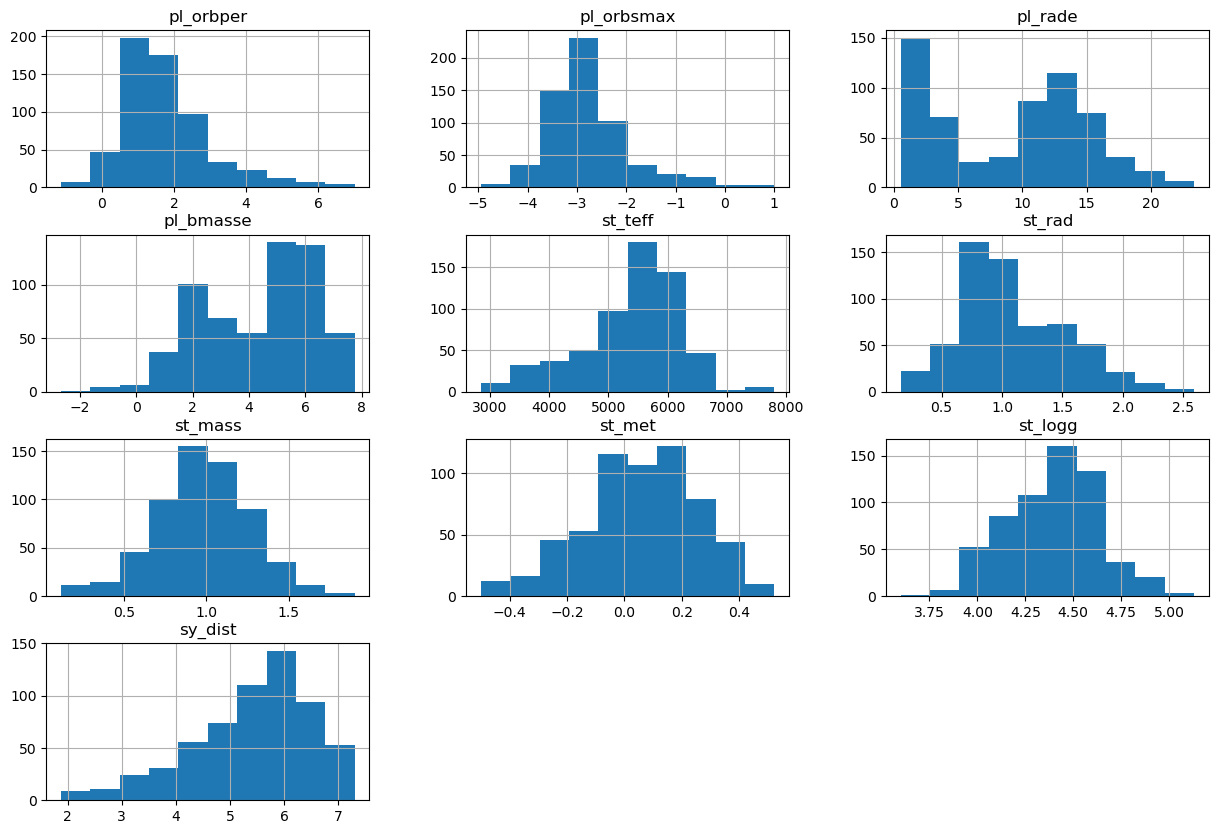

In [279]:
log_cluster_data_X.hist(bins=10, figsize=(15, 10));

### Histograms after log transformation and standardizing

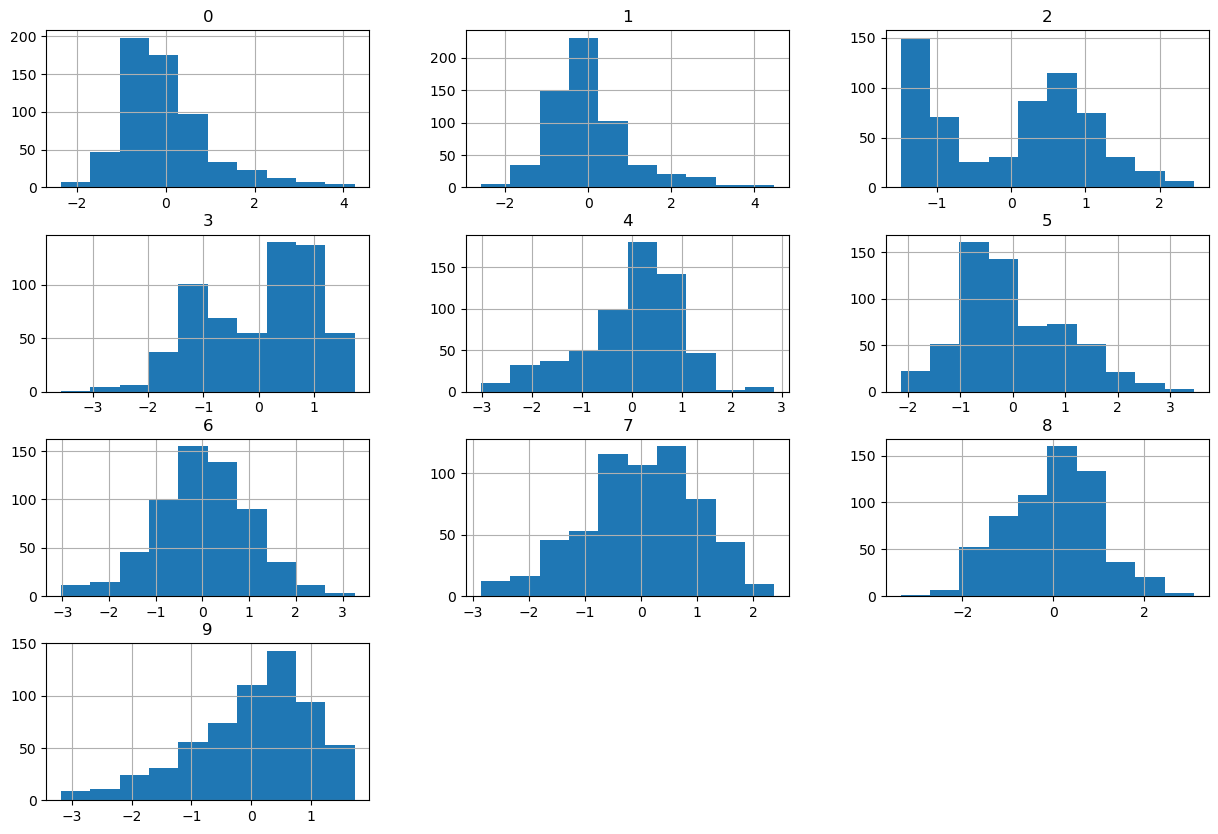

In [280]:
scaler = StandardScaler()
scaled_log_data_X = pd.DataFrame(scaler.fit_transform(log_cluster_data_X))
scaled_log_data_X.hist(bins=10, figsize=(15, 10));

In [281]:
scaled_log_data_X.describe()

,0,1,2,3,4,5,6,7,8,9
count,6.050000e+02,6.050000e+02,6.050000e+02,6.050000e+02,6.050000e+02,6.050000e+02,6.050000e+02,6.050000e+02,6.050000e+02,6.050000e+02
mean,-4.495944e-17,-4.342715e-16,4.760196e-16,2.954478e-17,2.385603e-17,-4.150950e-16,1.108388e-16,4.991416e-17,-3.994234e-15,3.356819e-16
std,1.000827e+00,1.000827e+00,1.000827e+00,1.000827e+00,1.000827e+00,1.000827e+00,1.000827e+00,1.000827e+00,1.000827e+00,1.000827e+00
min,-2.358420e+00,-2.582048e+00,-1.493292e+00,-3.574013e+00,-3.024137e+00,-2.141398e+00,-3.027167e+00,-2.862592e+00,-3.360047e+00,-3.177534e+00
25%,-5.799825e-01,-5.854528e-01,-1.084510e+00,-9.096008e-01,-4.896269e-01,-6.888115e-01,-5.907608e-01,-6.060395e-01,-7.400959e-01,-5.912434e-01
50%,-2.674658e-01,-2.158564e-01,2.821379e-01,3.036930e-01,2.048407e-01,-2.276729e-01,-2.579690e-02,6.066922e-02,6.279220e-02,2.053030e-01
75%,4.538272e-01,4.376578e-01,7.714637e-01,7.712169e-01,6.891873e-01,6.946044e-01,6.804079e-01,7.273779e-01,6.543940e-01,7.189973e-01
max,4.251947e+00,4.481400e+00,2.466523e+00,1.733068e+00,2.852127e+00,3.461436e+00,3.258056e+00,2.378764e+00,3.105316e+00,1.723505e+00


# Clustering on original data

In [282]:
silhoutte_score = []
inertia = []
min_clusters = 2
max_clusters = 11

for i in range(min_clusters,max_clusters):
    kmeans = KMeans(init="k-means++", n_clusters=i, random_state=0)
    estimator = make_pipeline(StandardScaler(), kmeans).fit(cluster_data_X)
    inertia.append(estimator[-1].inertia_)
    silhoutte_score.append(metrics.silhouette_score(
                cluster_data_X,
                estimator[-1].labels_,
                metric="euclidean",
            ))

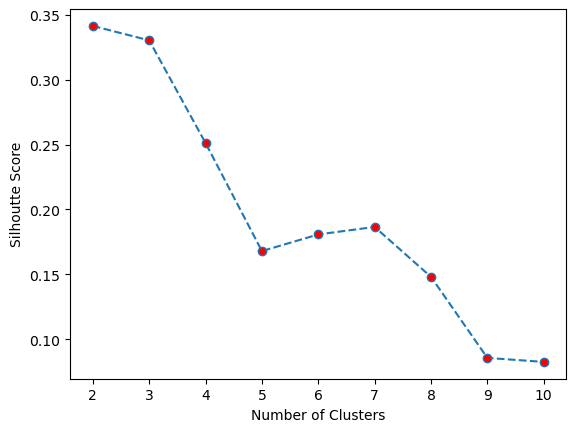

In [283]:
fig,ax = plt.subplots()

labels = list(range(min_clusters-1,max_clusters))

plt.plot(silhoutte_score,marker='o',markerfacecolor='red',linestyle='--')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhoutte Score')
ax.set_xticklabels(labels);

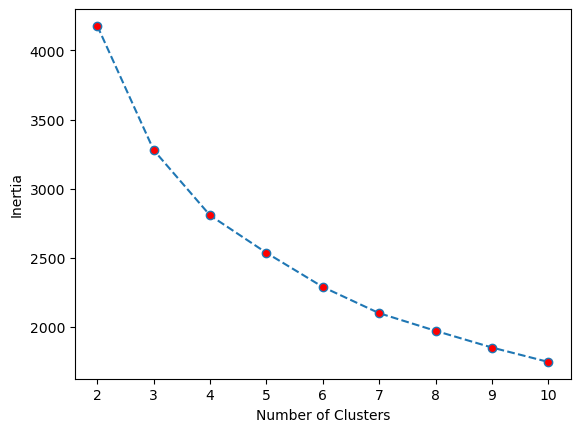

In [284]:
fig,ax = plt.subplots()

labels = list(range(min_clusters-1,max_clusters))

plt.plot(inertia,marker='o',markerfacecolor='red',linestyle='--')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Inertia')
ax.set_xticklabels(labels);

In [285]:
best_clusters = 3

kmeans = KMeans(init="k-means++", n_clusters=best_clusters, random_state=0)
estimator = make_pipeline(StandardScaler(), kmeans).fit(cluster_data_X)

In [286]:
cluster_data['cluster_labels'] = estimator[-1].labels_
cluster_data['cluster_labels'] = cluster_data['cluster_labels'].map({0:'Label 1',1:'Label 2', 2:'Label 3', 3:'Label 4'})

In [287]:
cluster_data.head()

,pl_orbper,pl_orbsmax,pl_rade,pl_bmasse,st_teff,st_rad,st_mass,st_met,st_logg,sy_dist,planet_type,cluster_labels
30,0.736547,0.01544,1.875,7.990,5172.0,0.94,0.91,0.35,4.43,12.5855,Super Earth,Label 2
80,13.240600,0.10550,10.870,874.000,5075.0,0.79,0.89,0.26,4.65,338.3860,Gas Giant,Label 2
81,2.994330,0.04360,16.030,740.510,6440.0,1.37,1.27,-0.03,4.22,655.0370,Gas Giant,Label 1
82,2.828042,0.04016,16.140,291.438,5675.0,1.12,1.08,0.16,4.38,1126.3700,Gas Giant,Label 1
83,4.035190,0.05100,9.920,415.704,5945.0,1.01,1.09,0.01,4.46,1148.9300,Gas Giant,Label 1


In [288]:
cluster_data.cluster_labels.value_counts()

Label 1    309
Label 2    291
Label 3      5
Name: cluster_labels, dtype: int64

In [289]:
cluster_data.planet_type.value_counts()

Gas Giant       368
Neptune-like    129
Super Earth     100
Terrestrial       8
Name: planet_type, dtype: int64

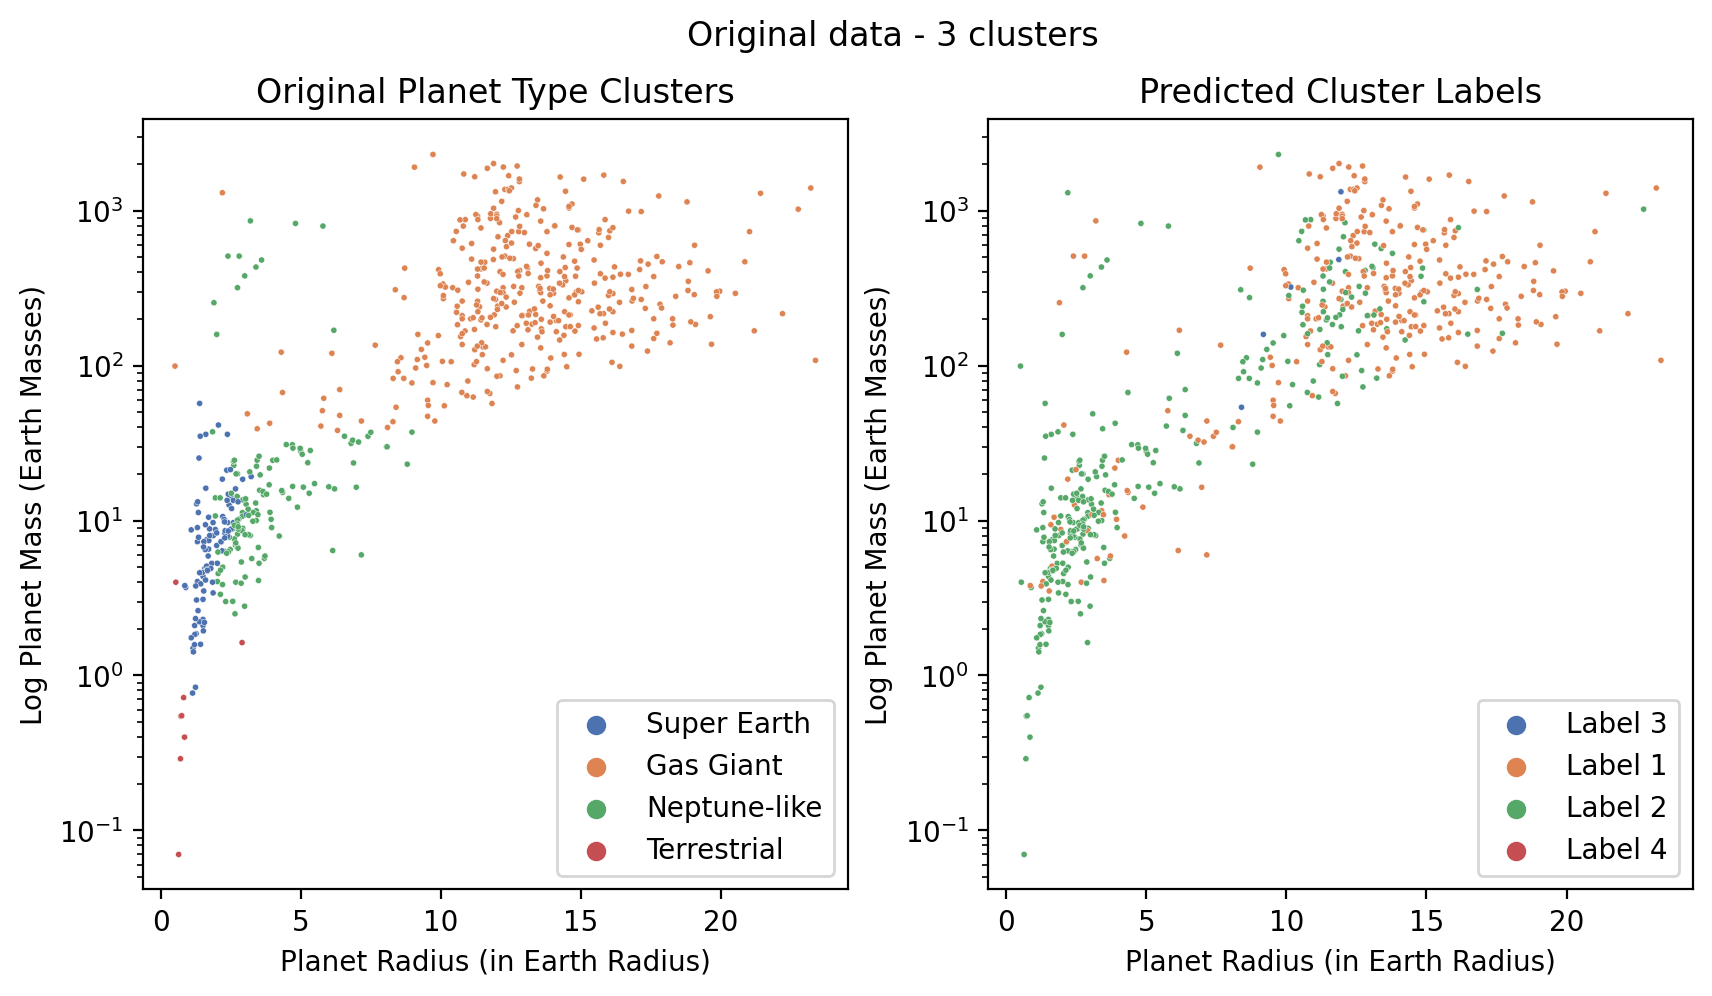

In [290]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5),dpi=200)
fig.suptitle('Original data - 3 clusters')
ax1.set_title('Original Planet Type Clusters')
sns.scatterplot(data=cluster_data, x='pl_rade', y='pl_bmasse', hue='planet_type', ax=ax1, s=5, palette="deep")
ax1.set_yscale('log')
ax1.set_xlabel('Planet Radius (in Earth Radius)')
ax1.set_ylabel('Log Planet Mass (Earth Masses)')
ax1.legend()

ax2.set_title('Predicted Cluster Labels')
sns.scatterplot(data=cluster_data, x='pl_rade', y='pl_bmasse', hue='cluster_labels', ax=ax2, s=5, palette="deep", hue_order=['Label 3','Label 1','Label 2','Label 4'])
ax2.set_yscale('log')
ax2.set_xlabel('Planet Radius (in Earth Radius)')
ax2.set_ylabel('Log Planet Mass (Earth Masses)')
ax2.legend();

# Clustering on log transformed data

In [291]:
silhoutte_score = []
inertia = []
min_clusters = 2
max_clusters = 11

for i in range(min_clusters,max_clusters):
    kmeans = KMeans(init="k-means++", n_clusters=i, random_state=0)
    estimator = make_pipeline(StandardScaler(), kmeans).fit(log_cluster_data_X)
    inertia.append(estimator[-1].inertia_)
    silhoutte_score.append(metrics.silhouette_score(
                log_cluster_data_X,
                estimator[-1].labels_,
                metric="euclidean",
            ))

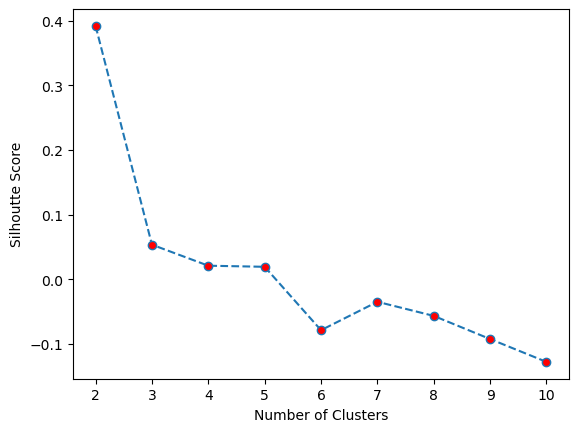

In [292]:
fig,ax = plt.subplots()

labels = list(range(min_clusters-1,max_clusters))

plt.plot(silhoutte_score,marker='o',markerfacecolor='red',linestyle='--')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhoutte Score')
ax.set_xticklabels(labels);

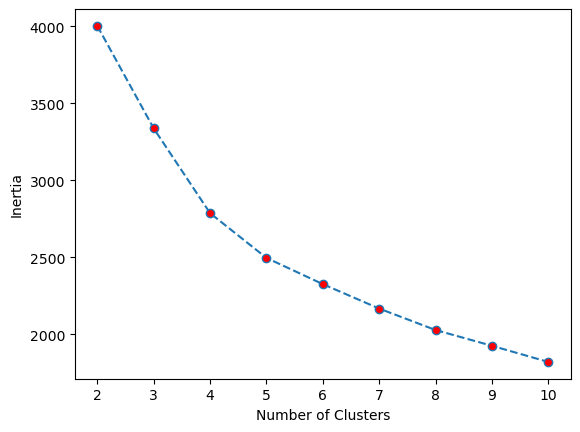

In [293]:
fig,ax = plt.subplots()

labels = list(range(min_clusters-1,max_clusters))

plt.plot(inertia,marker='o',markerfacecolor='red',linestyle='--')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Inertia')
ax.set_xticklabels(labels);

In [294]:
best_clusters = 3

kmeans = KMeans(init="k-means++", n_clusters=best_clusters, random_state=0)
estimator = make_pipeline(StandardScaler(), kmeans).fit(log_cluster_data_X)

In [295]:
cluster_data['cluster_labels'] = estimator[-1].labels_
cluster_data['cluster_labels'] = cluster_data['cluster_labels'].map({0:'Label 1',1:'Label 2', 2:'Label 3',3:'Label 4'})

In [296]:
cluster_data.head()

,pl_orbper,pl_orbsmax,pl_rade,pl_bmasse,st_teff,st_rad,st_mass,st_met,st_logg,sy_dist,planet_type,cluster_labels
30,0.736547,0.01544,1.875,7.990,5172.0,0.94,0.91,0.35,4.43,12.5855,Super Earth,Label 3
80,13.240600,0.10550,10.870,874.000,5075.0,0.79,0.89,0.26,4.65,338.3860,Gas Giant,Label 1
81,2.994330,0.04360,16.030,740.510,6440.0,1.37,1.27,-0.03,4.22,655.0370,Gas Giant,Label 1
82,2.828042,0.04016,16.140,291.438,5675.0,1.12,1.08,0.16,4.38,1126.3700,Gas Giant,Label 1
83,4.035190,0.05100,9.920,415.704,5945.0,1.01,1.09,0.01,4.46,1148.9300,Gas Giant,Label 1


In [297]:
cluster_data.cluster_labels.value_counts()

Label 1    297
Label 3    203
Label 2    105
Name: cluster_labels, dtype: int64

In [298]:
cluster_data.planet_type.value_counts()

Gas Giant       368
Neptune-like    129
Super Earth     100
Terrestrial       8
Name: planet_type, dtype: int64

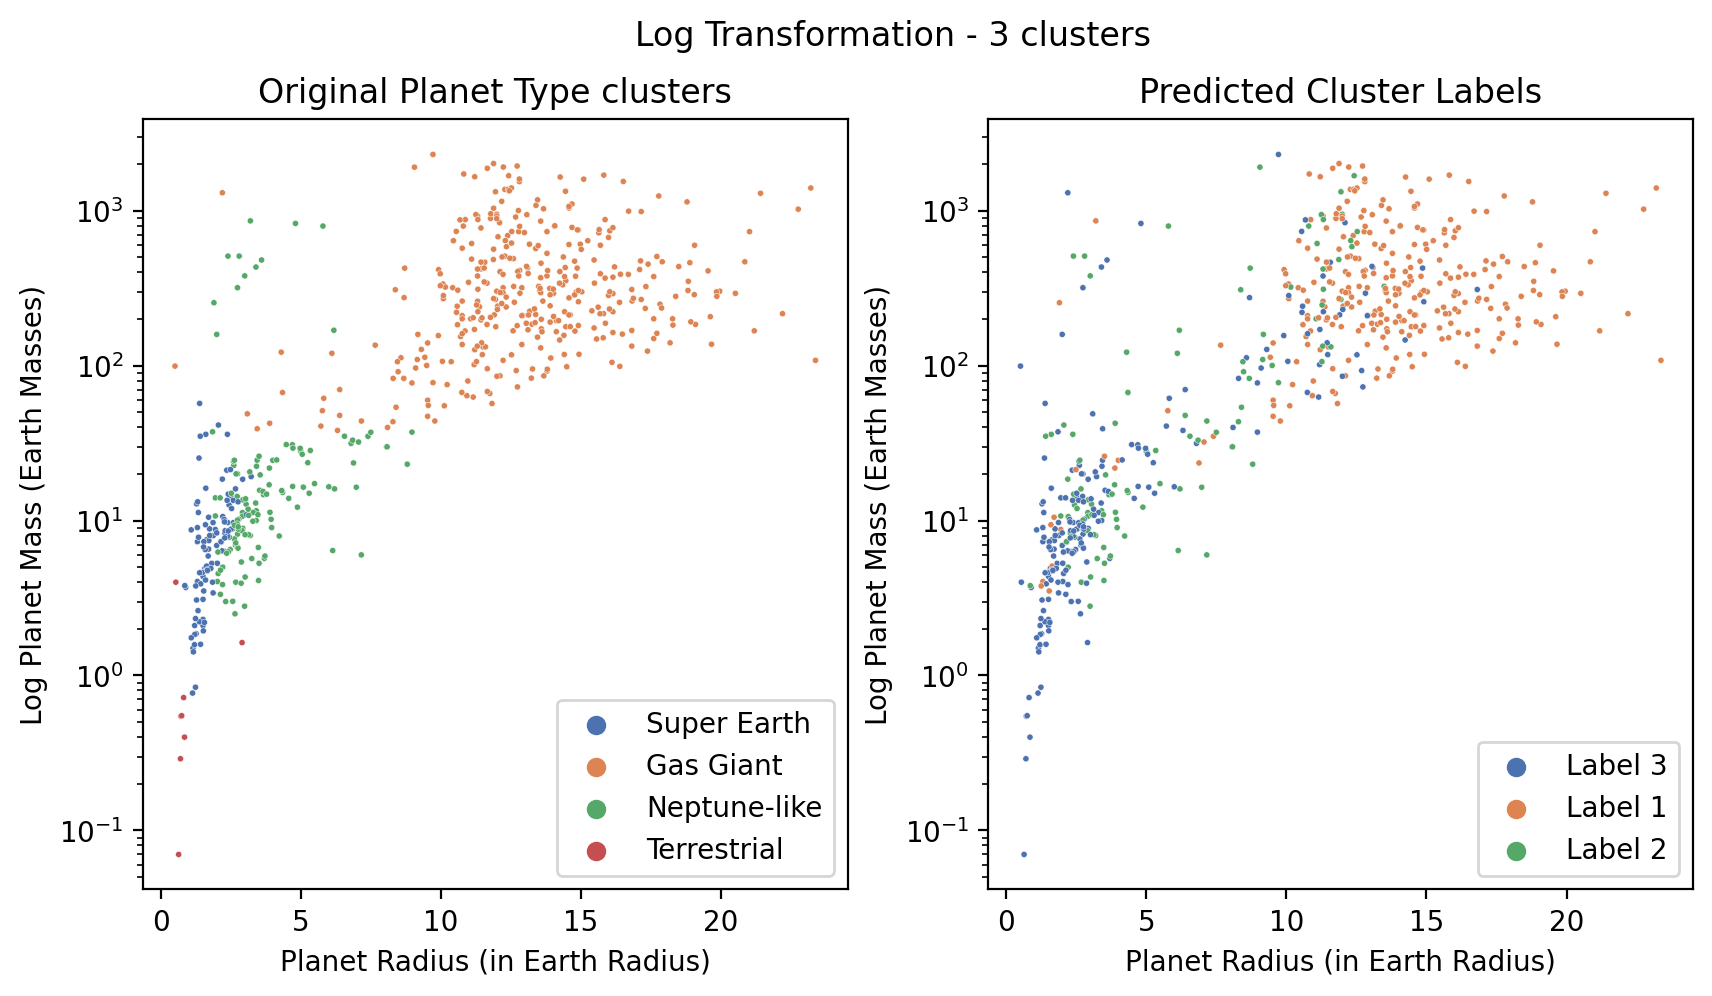

In [299]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5),dpi=200)
fig.suptitle('Log Transformation - 3 clusters')
ax1.set_title('Original Planet Type clusters')
sns.scatterplot(data=cluster_data, x='pl_rade', y='pl_bmasse', hue='planet_type', ax=ax1, s=5, palette="deep")
ax1.set_yscale('log')
ax1.set_xlabel('Planet Radius (in Earth Radius)')
ax1.set_ylabel('Log Planet Mass (Earth Masses)')
ax1.legend()

ax2.set_title('Predicted Cluster Labels')
sns.scatterplot(data=cluster_data, x='pl_rade', y='pl_bmasse', hue='cluster_labels', ax=ax2, s=5, palette="deep", hue_order=['Label 3','Label 1','Label 2'])
ax2.set_yscale('log')
ax2.set_xlabel('Planet Radius (in Earth Radius)')
ax2.set_ylabel('Log Planet Mass (Earth Masses)')
ax2.legend();

# Clustering on PCA transformed data

In [300]:
pca = PCA()
pca.fit(scaled_log_data_X);

In [301]:
pca.explained_variance_ratio_

array([4.99355795e-01, 2.18532716e-01, 1.02789608e-01, 8.27647604e-02,
       4.45126925e-02, 2.72955326e-02, 1.62378671e-02, 6.28005780e-03,
       2.05277234e-03, 1.78197206e-04])

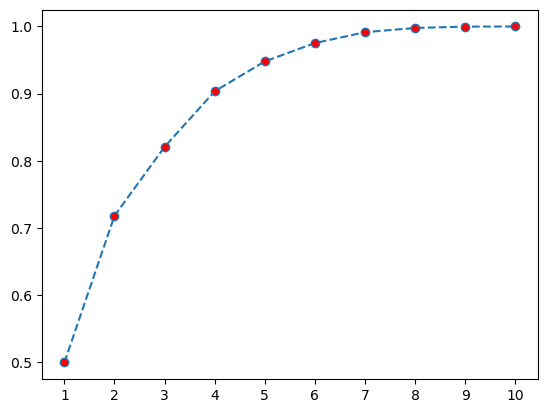

In [302]:
fig, ax = plt.subplots()
labels = list(range(1,11))
plt.plot(range(1,11),pca.explained_variance_ratio_.cumsum(), marker='o',linestyle='--',markerfacecolor='red')
ax.set_xticks(labels);

In [303]:
pca = PCA(n_components=3)
pca_data_X = pca.fit_transform(scaled_log_data_X);

In [304]:
silhoutte_score = []
inertia = []
min_clusters = 2
max_clusters = 11

for i in range(min_clusters,max_clusters):
    kmeans = KMeans(init="k-means++", n_clusters=i, random_state=0)
    estimator = make_pipeline(kmeans).fit(pca_data_X)
    inertia.append(estimator[-1].inertia_)
    silhoutte_score.append(metrics.silhouette_score(
                pca_data_X,
                estimator[-1].labels_,
                metric="euclidean",
            ))

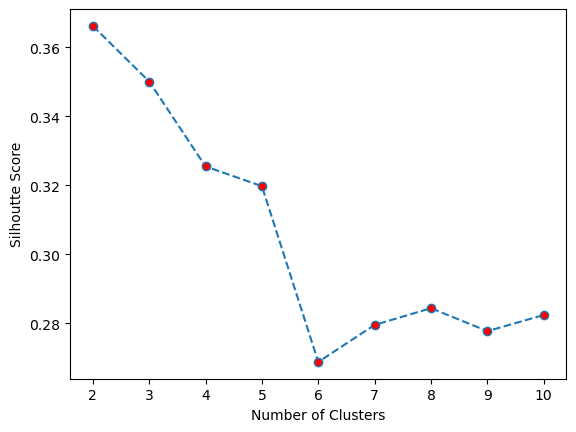

In [305]:
fig,ax = plt.subplots()

labels = list(range(min_clusters-1,max_clusters))

plt.plot(silhoutte_score,marker='o',markerfacecolor='red',linestyle='--')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhoutte Score')
ax.set_xticklabels(labels);

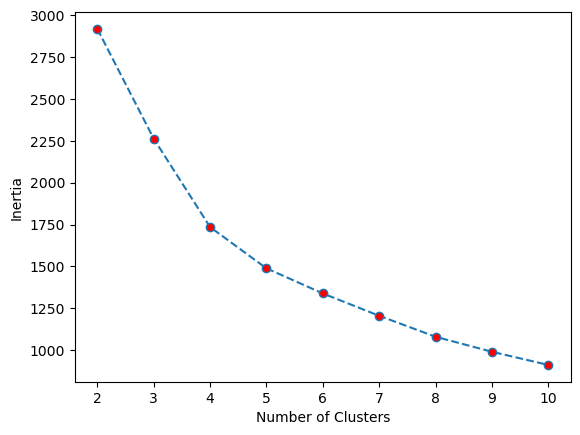

In [306]:
fig,ax = plt.subplots()

labels = list(range(min_clusters-1,max_clusters))

plt.plot(inertia,marker='o',markerfacecolor='red',linestyle='--')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Inertia')
ax.set_xticklabels(labels);

In [307]:
best_clusters = 3

kmeans = KMeans(init="k-means++", n_clusters=best_clusters, random_state=0)
estimator = make_pipeline(kmeans).fit(pca_data_X)

In [308]:
cluster_data['cluster_labels'] = estimator[-1].labels_
cluster_data['cluster_labels'] = cluster_data['cluster_labels'].map({0:'Label 1',1:'Label 2', 2:'Label 3',3:'Label 4'})
cluster_data[['component_1','component_2','component_3']] = pca_data_X

In [309]:
cluster_data.head()

,pl_orbper,pl_orbsmax,pl_rade,pl_bmasse,st_teff,st_rad,st_mass,st_met,st_logg,sy_dist,planet_type,cluster_labels,component_1,component_2,component_3
30,0.736547,0.01544,1.875,7.990,5172.0,0.94,0.91,0.35,4.43,12.5855,Super Earth,Label 2,1.953445,-1.967731,1.070381
80,13.240600,0.10550,10.870,874.000,5075.0,0.79,0.89,0.26,4.65,338.3860,Gas Giant,Label 3,0.200991,0.083682,-2.248161
81,2.994330,0.04360,16.030,740.510,6440.0,1.37,1.27,-0.03,4.22,655.0370,Gas Giant,Label 1,-2.511367,-0.741866,0.382479
82,2.828042,0.04016,16.140,291.438,5675.0,1.12,1.08,0.16,4.38,1126.3700,Gas Giant,Label 1,-1.509425,-1.201108,-0.732628
83,4.035190,0.05100,9.920,415.704,5945.0,1.01,1.09,0.01,4.46,1148.9300,Gas Giant,Label 1,-1.026970,-0.492228,-0.334984


In [310]:
cluster_data.cluster_labels.value_counts()

Label 1    289
Label 2    210
Label 3    106
Name: cluster_labels, dtype: int64

In [311]:
cluster_data.planet_type.value_counts()

Gas Giant       368
Neptune-like    129
Super Earth     100
Terrestrial       8
Name: planet_type, dtype: int64

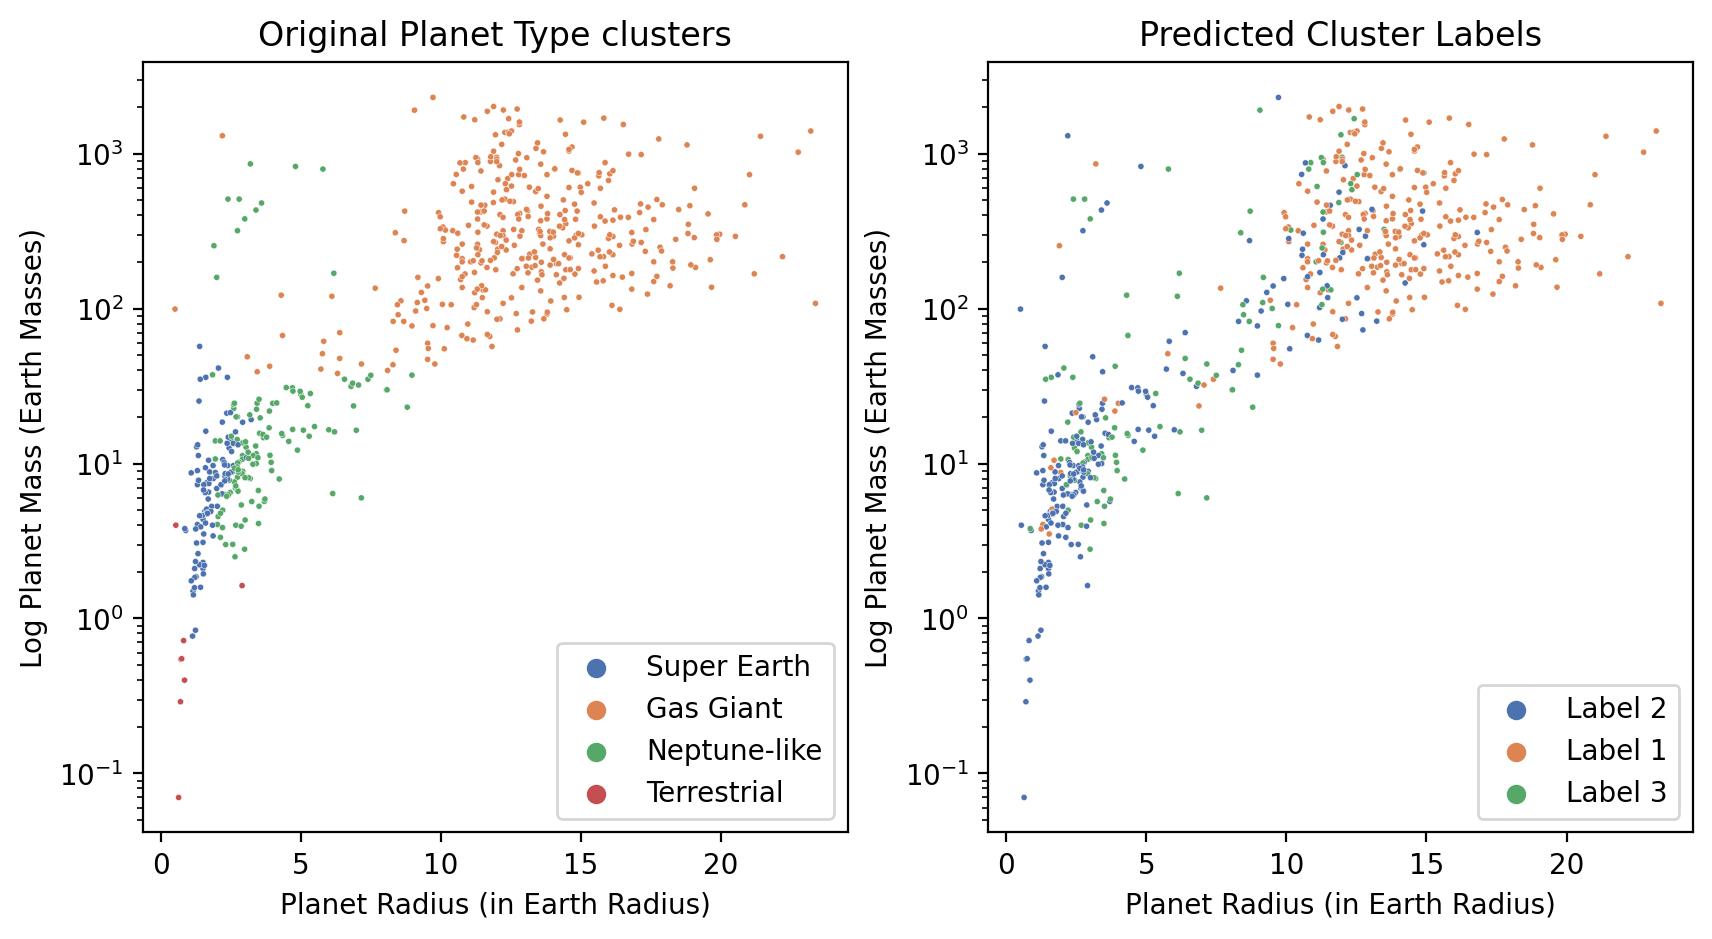

In [312]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5),dpi=200)

ax1.set_title('Original Planet Type clusters')
sns.scatterplot(data=cluster_data, x='pl_rade', y='pl_bmasse', hue='planet_type', ax=ax1, s=5, palette="deep")
ax1.set_yscale('log')
ax1.set_xlabel('Planet Radius (in Earth Radius)')
ax1.set_ylabel('Log Planet Mass (Earth Masses)')
ax1.legend()

ax2.set_title('Predicted Cluster Labels')
sns.scatterplot(data=cluster_data, x='pl_rade', y='pl_bmasse', hue='cluster_labels', ax=ax2, s=5, palette="deep", hue_order=['Label 2','Label 1','Label 3'])
ax2.set_yscale('log')
ax2.set_xlabel('Planet Radius (in Earth Radius)')
ax2.set_ylabel('Log Planet Mass (Earth Masses)')
ax2.legend();

In [313]:
scaled_log_data_X.columns = cluster_data.columns.values[0:10]

In [314]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

fig = px.scatter_3d(cluster_data, x='component_1', y='component_2', z='component_3', color='cluster_labels')
fig.update_layout(
    autosize=False,
    width=1000,
    height=1000,)

fig.show()

In [315]:
loadings

array([[ 0.01617701,  0.95763132, -0.27558817],
       [-0.11027836,  0.9590585 , -0.25296216],
       [-0.7671372 , -0.34613011, -0.22179624],
       [-0.70411343, -0.28202171, -0.43096795],
       [-0.89076579,  0.14558856,  0.23691243],
       [-0.91026685,  0.13202401,  0.24998504],
       [-0.93860048,  0.09509377,  0.16448609],
       [-0.27832869, -0.28093446, -0.61678898],
       [ 0.86939474, -0.15836527, -0.28073136],
       [-0.75418358, -0.03284941, -0.22319906]])

In [316]:
loadings_df = pd.DataFrame(loadings)
loadings_df.index = scaled_log_data_X.columns
loadings_df

,0,1,2
pl_orbper,0.016177,0.957631,-0.275588
pl_orbsmax,-0.110278,0.959058,-0.252962
pl_rade,-0.767137,-0.346130,-0.221796
pl_bmasse,-0.704113,-0.282022,-0.430968
st_teff,-0.890766,0.145589,0.236912
st_rad,-0.910267,0.132024,0.249985
st_mass,-0.938600,0.095094,0.164486
st_met,-0.278329,-0.280934,-0.616789
st_logg,0.869395,-0.158365,-0.280731
sy_dist,-0.754184,-0.032849,-0.223199


In [317]:
viz_features = {0:'pl_orbper', 2:'pl_rade', 3:'pl_bmasse', 9:'sy_dist'}
fig = px.scatter(cluster_data, x='component_1', y='component_2', color='cluster_labels')
fig.update_layout(
    autosize=False,
    width=1000,
    height=1000,)

for i, feature in viz_features.items():
    fig.add_annotation(
        ax=0, ay=0,
        axref="x", ayref="y", 
        x=loadings[i, 0],
        y=loadings[i, 1],
        showarrow=True,
        arrowsize=2,
        arrowhead=2,
        xanchor="right",
        yanchor="top"
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0, 
        xanchor="center",
        yanchor="bottom",
        text=feature,
        yshift=5,
    )

fig.show()

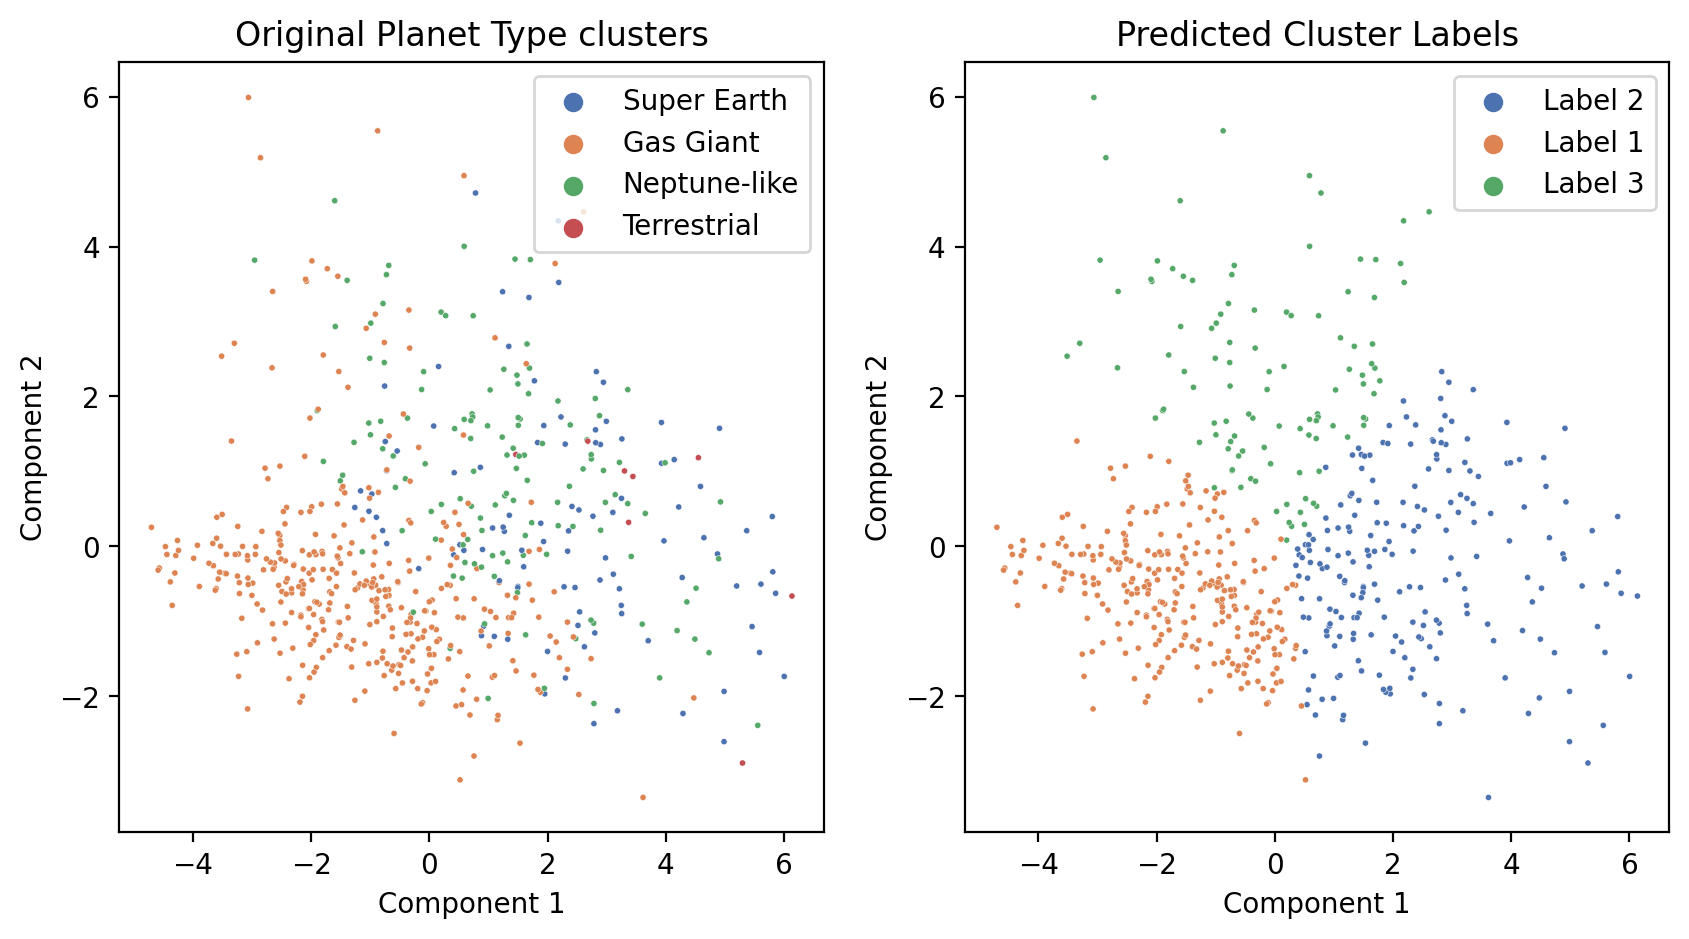

In [318]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5),dpi=200)

ax1.set_title('Original Planet Type clusters')
sns.scatterplot(data=cluster_data, x='component_1', y='component_2', hue='planet_type', ax=ax1, s=5, palette="deep")
ax1.set_xlabel('Component 1')
ax1.set_ylabel('Component 2')
ax1.legend()

ax2.set_title('Predicted Cluster Labels')
sns.scatterplot(data=cluster_data, x='component_1', y='component_2', hue='cluster_labels', ax=ax2, s=5, palette="deep", hue_order=['Label 2','Label 1','Label 3'])
ax2.set_xlabel('Component 1')
ax2.set_ylabel('Component 2')
ax2.legend();

# Clustering on subset of features

In [319]:
subset_features = ['pl_rade','pl_bmasse','pl_orbper']

In [320]:
silhoutte_score = []
inertia = []
min_clusters = 2
max_clusters = 11

for i in range(min_clusters,max_clusters):
    kmeans = KMeans(init="k-means++", n_clusters=i, random_state=0)
    estimator = make_pipeline(StandardScaler(), kmeans).fit(cluster_data_X.loc[:,subset_features])
    inertia.append(estimator[-1].inertia_)
    silhoutte_score.append(metrics.silhouette_score(
                cluster_data_X.loc[:,subset_features],
                estimator[-1].labels_,
                metric="euclidean",
            ))

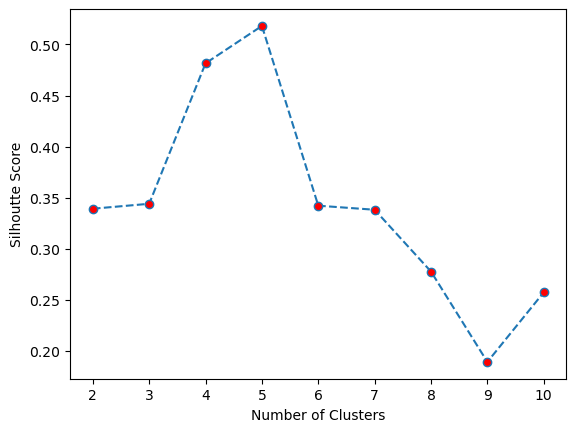

In [321]:
fig,ax = plt.subplots()

labels = list(range(min_clusters-1,max_clusters))

plt.plot(silhoutte_score,marker='o',markerfacecolor='red',linestyle='--')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhoutte Score')
ax.set_xticklabels(labels);

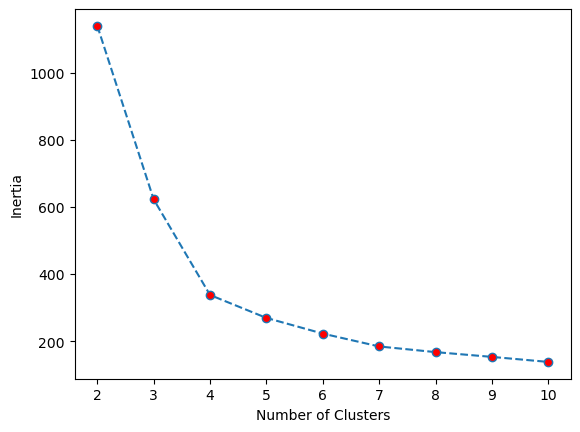

In [322]:
fig,ax = plt.subplots()

labels = list(range(min_clusters-1,max_clusters))

plt.plot(inertia,marker='o',markerfacecolor='red',linestyle='--')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Inertia')
ax.set_xticklabels(labels);

In [323]:
best_clusters = 3

kmeans = KMeans(init="k-means++", n_clusters=best_clusters, random_state=0)
estimator = make_pipeline(StandardScaler(), kmeans).fit(cluster_data_X.loc[:,subset_features])

In [324]:
cluster_data['cluster_labels'] = estimator[-1].labels_
cluster_data['cluster_labels'] = cluster_data['cluster_labels'].map({0:'Label 1',1:'Label 2', 2:'Label 3', 3:'Label 4'})

In [325]:
cluster_data.head()

,pl_orbper,pl_orbsmax,pl_rade,pl_bmasse,st_teff,st_rad,st_mass,st_met,st_logg,sy_dist,planet_type,cluster_labels,component_1,component_2,component_3
30,0.736547,0.01544,1.875,7.990,5172.0,0.94,0.91,0.35,4.43,12.5855,Super Earth,Label 2,1.953445,-1.967731,1.070381
80,13.240600,0.10550,10.870,874.000,5075.0,0.79,0.89,0.26,4.65,338.3860,Gas Giant,Label 1,0.200991,0.083682,-2.248161
81,2.994330,0.04360,16.030,740.510,6440.0,1.37,1.27,-0.03,4.22,655.0370,Gas Giant,Label 1,-2.511367,-0.741866,0.382479
82,2.828042,0.04016,16.140,291.438,5675.0,1.12,1.08,0.16,4.38,1126.3700,Gas Giant,Label 1,-1.509425,-1.201108,-0.732628
83,4.035190,0.05100,9.920,415.704,5945.0,1.01,1.09,0.01,4.46,1148.9300,Gas Giant,Label 1,-1.026970,-0.492228,-0.334984


In [326]:
cluster_data.cluster_labels.value_counts()

Label 1    329
Label 2    271
Label 3      5
Name: cluster_labels, dtype: int64

In [327]:
cluster_data.planet_type.value_counts()

Gas Giant       368
Neptune-like    129
Super Earth     100
Terrestrial       8
Name: planet_type, dtype: int64

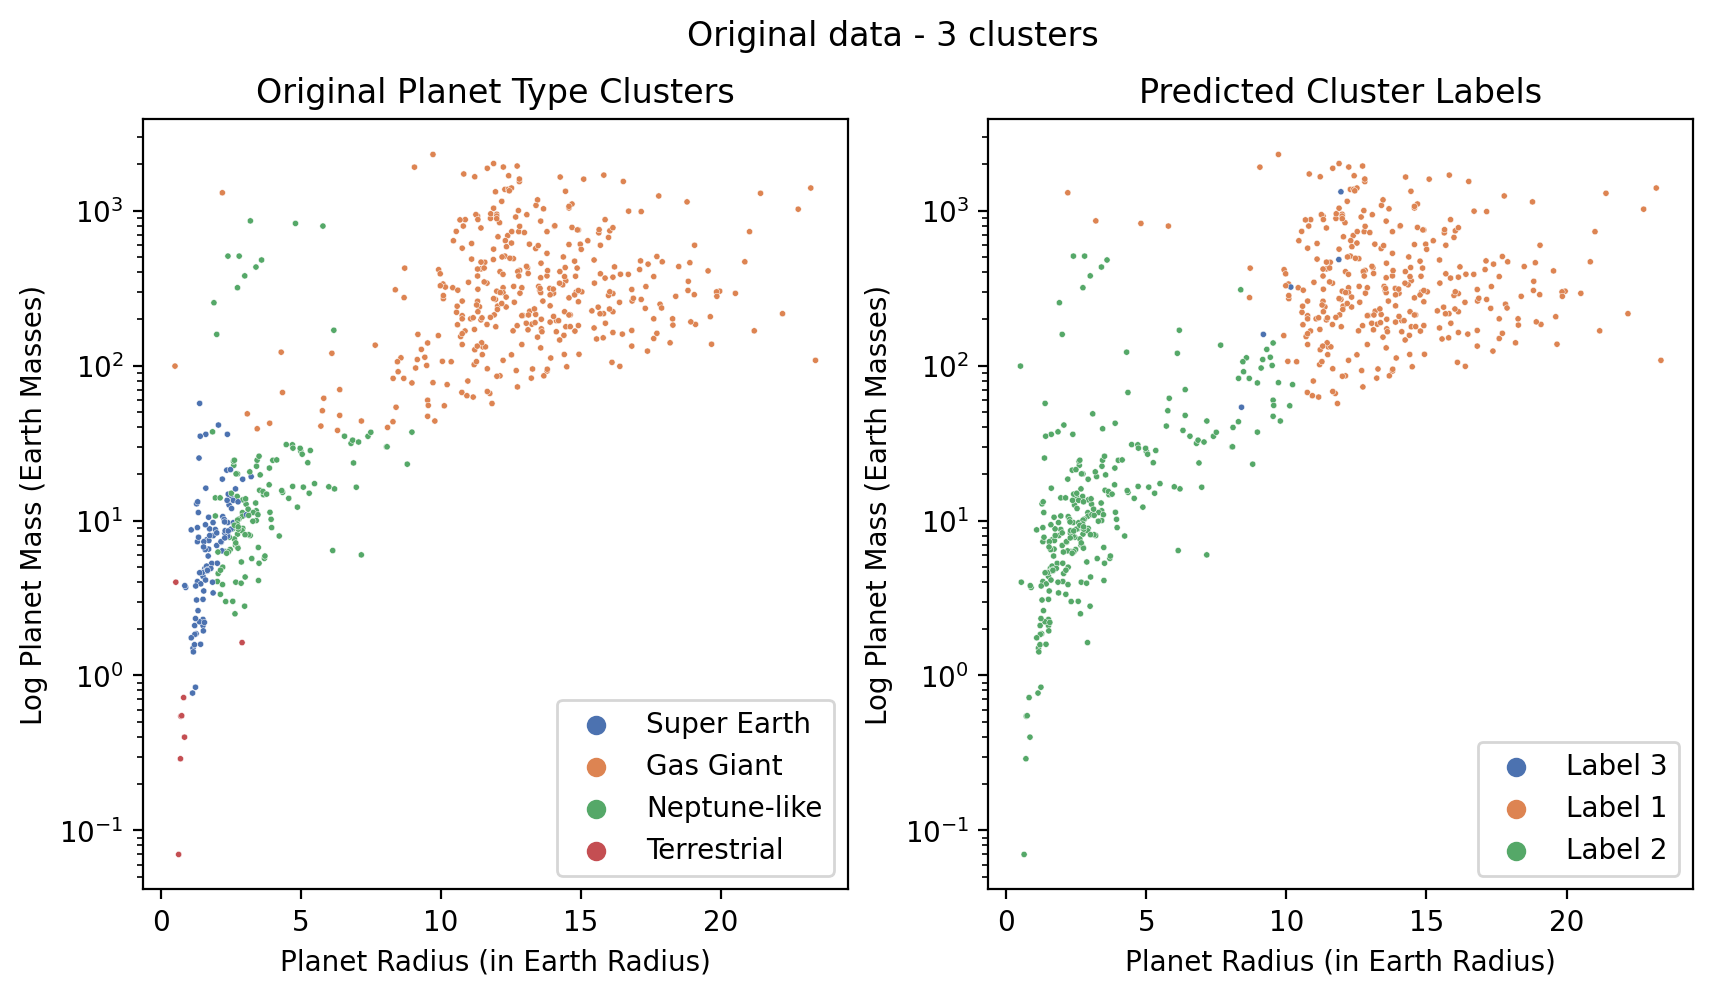

In [328]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5),dpi=200)
fig.suptitle('Original data - 3 clusters')
ax1.set_title('Original Planet Type Clusters')
sns.scatterplot(data=cluster_data, x='pl_rade', y='pl_bmasse', hue='planet_type', ax=ax1, s=5, palette="deep")
ax1.set_yscale('log')
ax1.set_xlabel('Planet Radius (in Earth Radius)')
ax1.set_ylabel('Log Planet Mass (Earth Masses)')
ax1.legend()

ax2.set_title('Predicted Cluster Labels')
sns.scatterplot(data=cluster_data, x='pl_rade', y='pl_bmasse', hue='cluster_labels', ax=ax2, s=5, palette="deep", hue_order=['Label 3','Label 1','Label 2'])
ax2.set_yscale('log')
ax2.set_xlabel('Planet Radius (in Earth Radius)')
ax2.set_ylabel('Log Planet Mass (Earth Masses)')
ax2.legend();